In [37]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# from astropy.constants import mu0

import astropy.units as u

# increase the font size
plt.rcParams.update({'font.size': 12})

flares = pd.read_csv("../results/flare_phases_and_energies.csv")
phases = flares.phase.values

In [12]:
B0 = 1000 * u.G 

Rs = 1.2 * u.R_sun
M = B0 / Rs**3

aplanet = 11.7 # semi-major axis

# plot a dipole field line from the big circle
theta = np.linspace(-np.pi/2, np.pi/2, 100)

# now rotate the field by alpha degrees in the x-y plane
rstar = 1
nbins = 200

phi = np.linspace(0., 1, nbins)
alphamax = 80 * np.pi/180
alphas = (alphamax * np.cos(phi * 2 * np.pi))

def get_surface_latitudes(aplanet, alphas, rstar = 1):
  
  reqs =np.array ([aplanet / (np.cos(a)**2) for a in alphas])


  r = [req * np.sin(theta)**2 for req in reqs]
  # convert to cartesian coordinates
  # x = r * np.sin(theta)
  # y = r * np.cos(theta)


  # xs = [x*np.cos(alpha) - y*np.sin(alpha) for alpha, x, y in zip(alphas, x, y)]
  # ys = [x*np.sin(alpha) + y*np.cos(alpha) for alpha, x, y in zip(alphas, x, y)]


  # calc the latitude at rstar
  
  lat = np.concatenate([np.arcsin(np.sqrt(rstar / reqs)), np.arcsin(np.sqrt(rstar/reqs))])
  nreqs = np.concatenate([reqs, reqs])

  xstar = nreqs * np.sin(lat) * np.sin(lat)**2
  ystar = nreqs * np.cos(lat) * np.sin(lat)**2


  # rotate the xstar, ystar by alpha
  nalphas = np.concatenate([alphas, -alphas])
  xstars = np.array([x_*np.cos(alpha) - y_*np.sin(alpha) for alpha, x_, y_ in list(zip(nalphas, xstar, ystar))])
  ystars = np.array([x_*np.sin(alpha) + y_*np.cos(alpha) for alpha, x_, y_ in list(zip(nalphas, xstar, ystar))])


  return np.arctan(np.array(ystars)/np.array(xstars)) * 180 / np.pi


surfacelats = get_surface_latitudes(aplanet, alphas)

# fig, ax1 = plt.subplots(1, 1, figsize=(10,10))

# mask = nalphas > lat



(0.0, 1.0)

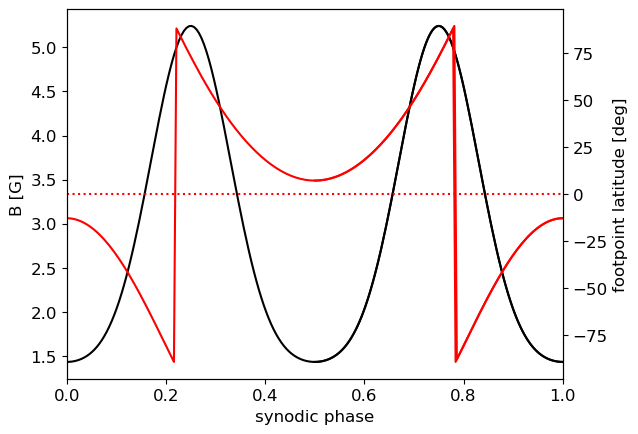

In [13]:
B_0 = 2100
B = B_0 * (rstar / aplanet)**3 * (1 + 3*np.cos(alphas)**2)
plt.figure()
plt.plot(phi, B  , label='B [G]', c="k")
plt.plot(phi+0.5, B  , c="k")
plt.ylabel('B [G]')
plt.xlabel("synodic phase")
# add a dual axis
ax2 = plt.gca().twinx()
ax2.plot(phi, surfacelats[:nbins] , label='footpoint latitude [deg]', c='red')
ax2.plot(phi+0.5, surfacelats[nbins:],  c='red')
ax2.axhline(0, color='red', linestyle=':')
ax2.set_ylabel('footpoint latitude [deg]')

# repeat with phi +0.5



plt.xlim(0,1)



In [14]:
prot, porb = 1.415, 6.9594
prot = porb / 5
psyn = 1 / (1/prot - 1/porb)
psyn / porb

0.25

In [15]:
6.9594 / 5

1.39188

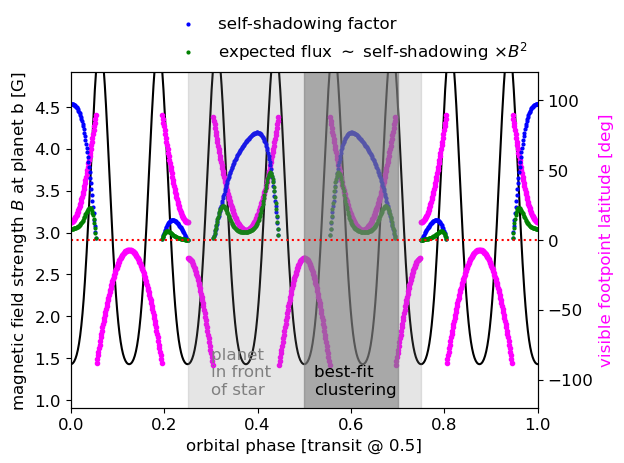

In [16]:
# make 10 repeats of B and surfacelats[:21] 
B10 = np.concatenate([B]*10)
surfacelats10 = np.concatenate([surfacelats[:200]]*10)

phi10 = np.concatenate([phi + i for i in range(10)]) * psyn / porb

phimask = (phi10>0.25) & (phi10<0.75)

foreshortening = np.abs(np.cos((phi10-0.5) * 2 * np.pi) * np.cos(surfacelats10/180 * np.pi))

plt.figure()
plt.plot(phi10, B10 , c="k")
plt.ylabel('magnetic field strength $B$ at planet b [G]')
plt.xlabel("orbital phase [transit @ 0.5]")
plt.ylim(np.mean(B10) - 2, np.mean(B10) + 2)
# add a dual axis
ax2 = plt.gca().twinx()
surfacelats10[~phimask] = -surfacelats10[~phimask]

mask_lower_hem = surfacelats10 > 0

ax2.scatter(phi10, surfacelats10  , c='magenta', marker=".")
ax2.scatter(phi10[mask_lower_hem], foreshortening[mask_lower_hem] * 1e2  , 
           c='blue', label='self-shadowing factor' , s=4)

ax2.scatter(phi10[mask_lower_hem], foreshortening[mask_lower_hem] * B10[mask_lower_hem]**2 * 4, 
           c='green',  label=r'expected flux $\sim$ self-shadowing $\times B^2$', s=4)

plt.text(0.52, 0.04, 'best-fit \nclustering', color='k', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.3, 0.04, 'planet \nin front\nof star', color='grey', fontsize=12, transform=plt.gca().transAxes)
plt.legend(loc=(0.2,1.01), frameon=False, fontsize=12)
# shade the region between 0.5 and 0.7
plt.fill_between([0.5, 0.7], -190, 190, color='gray', alpha=0.6)
plt.fill_between([0.25, 0.75], -190, 190, color='gray', alpha=0.2)
plt.ylim(-120,120)


# plt.text(-0.1, 1.1, fr'mag. obl.={alphamax*180/np.pi:.0f}$^\circ$', transform=plt.gca().transAxes, fontsize=13)
ax2.axhline(0, color='red', linestyle=':')
ax2.set_ylabel('visible footpoint latitude [deg]', color='magenta')
plt.xlim(0,1)

plt.tight_layout()
plt.savefig('../plots/paper/toy_model.png', dpi=300)

(1280000, 4)


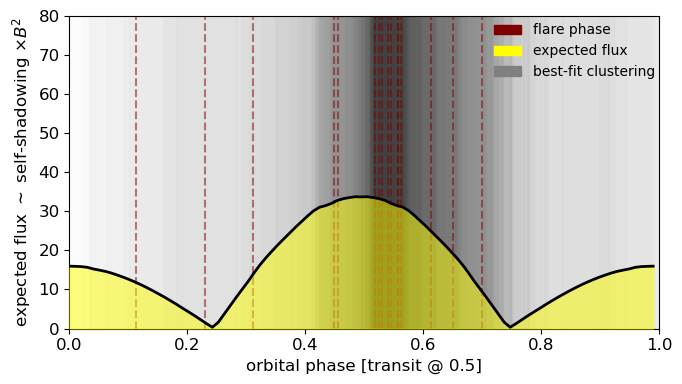

In [116]:
# make 10 repeats of B and surfacelats[:21] 
plt.figure(figsize=(7,4))

phis = []
fluxes = []

for a in np.linspace(5, 85, 50):
    alphamax = a * np.pi/180
    alphas = (alphamax * np.cos(phi * 2 * np.pi))
    B = B_0 * (rstar / aplanet)**3 * (1 + 3*np.cos(alphas)**2)

    surfacelats = get_surface_latitudes(aplanet, alphas)

    for offset in np.linspace(0., 0.25, 50):

        B10 = np.concatenate([B]*10)
        surfacelats10 = np.concatenate([surfacelats[:200]]*10)

        phi10 = np.concatenate([phi + i for i in range(10)]) * psyn / porb + offset
        surfacelats10 = surfacelats10[phi10 > 1]
        B10 = B10[phi10 > 1]
        phi10 = phi10[phi10 > 1] - 1.
        
        
        phimask = (phi10>0.25) & (phi10<0.75)

        foreshortening = np.abs(np.cos((phi10-0.5) * 2 * np.pi) * np.cos(surfacelats10/180 * np.pi))

        surfacelats10[~phimask] = -surfacelats10[~phimask]

        mask_lower_hem = surfacelats10 > 0

        phis.append(phi10[mask_lower_hem])
        fluxes.append(foreshortening[mask_lower_hem] * B10[mask_lower_hem]**2 * 4)

        # plt.plot(phi10[mask_lower_hem],foreshortening[mask_lower_hem] * B10[mask_lower_hem]**2 * 4 ,
        #          zorder=10, linewidth=1)

        # # fill area below the curve
        # plt.fill_between(phi10[mask_lower_hem], 0, foreshortening[mask_lower_hem] * B10[mask_lower_hem]**2 * 4, 
        #                  color="yellow", alpha=.1, zorder=10)
        
fluxes = np.concatenate(fluxes)
phis = np.concatenate(phis)


# bin the fluxes in phi 
bins = np.linspace(0, 1, 100)
binned_fluxes = np.array([fluxes[(phis > bins[i]) & (phis < bins[i+1])].mean() for i in range(len(bins)-1)])

plt.plot(bins[:-1], binned_fluxes, color='k', linewidth=2, zorder=20)

# fill area below the curve
plt.fill_between(bins[:-1], 0, binned_fluxes, color="yellow", alpha=.5, zorder=10)

plt.ylabel(r'expected flux $\sim$ self-shadowing $\times B^2$', color='k')
plt.xlabel("orbital phase [transit @ 0.5]")
plt.ylim(0,80)


# load best-fit clustering params

path = "../results/201_modulated_samples.npy"
samples = np.load(path)

# flatten samples 
samples = samples.reshape(-1, 4)
print(samples.shape)

for i in range(100):
    #choose a random sample
    sample = samples[np.random.randint(0, len(samples))]
    # get the parameters
    phi0, dphi = sample[2], sample[3]
    plt.fill_between([phi0, phi0 + dphi], 0, 120, color='k', alpha=0.01)

for phase in phases:
    plt.axvline((phase+0.5)%1, color='maroon', linestyle='--', alpha=0.5)


# make a legend with red dashed line, yellow shaded area, and black shaded area
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='maroon', label='flare phase')
yellow_patch = mpatches.Patch(color='yellow', label='expected flux')
black_patch = mpatches.Patch(color='grey', label='best-fit clustering')
plt.legend(handles=[red_patch, yellow_patch, black_patch], loc=(0.71, 0.78), frameon=False, fontsize=10)

plt.xlim(0,1)

plt.tight_layout()
plt.savefig('../plots/paper/toy_model_obliquity_averaged.png', dpi=300)

(2000,) (200,) (200,) (2000,)
(930,) (930,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(928,) (928,)
(2000,) (200,) (200,) (2000,)
(9

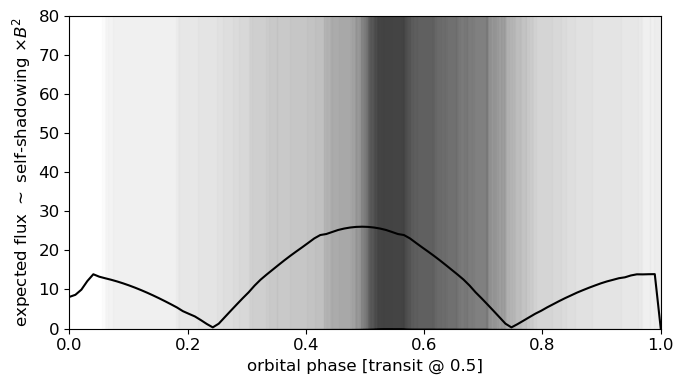

In [18]:
# make 10 repeats of B and surfacelats[:21] 
plt.figure(figsize=(7,4))

vals = []
phis = []
for offset in np.linspace(0., 0.25, 100):

    B10 = np.concatenate([B]*10)


    surfacelats10 = np.concatenate([surfacelats[:200]]*10)

    phi10 = np.concatenate([phi + i for i in range(10)]) * psyn / porb + offset

    phimask = (phi10>0.25) & (phi10<0.75)

    print(B10.shape, B.shape, surfacelats[:200].shape, phi10.shape)

    foreshortening = np.abs(np.cos((phi10-0.5) * 2 * np.pi) * np.cos(surfacelats10/180 * np.pi))

    surfacelats10[~phimask] = -surfacelats10[~phimask]

    mask_lower_hem = surfacelats10 > 0

    print(foreshortening[mask_lower_hem].shape, B10[mask_lower_hem].shape)

    vals.append(foreshortening[mask_lower_hem] * B10[mask_lower_hem]**2 * 4)
    phis.append(phi10[mask_lower_hem])

# bin the values in phi
vals = np.concatenate(vals)
phis = np.concatenate(phis)

phibins = np.linspace(0, 1, 100)
binned_vals = np.zeros_like(phibins)
for i in range(len(phibins) - 1):
    mask = (phis > phibins[i]) & (phis < phibins[i+1])
    binned_vals[i] = np.mean(vals[mask])

plt.plot(phibins, binned_vals, color='k')
# plt.scatter(phi10[mask_lower_hem],vals/10 , s=1, color="yellow", zorder=10)
plt.ylabel(r'expected flux $\sim$ self-shadowing $\times B^2$', color='k')
plt.xlabel("orbital phase [transit @ 0.5]")
plt.ylim(0,80)


# load best-fit clustering params

path = "../results/201_modulated_samples.npy"
samples = np.load(path)

# flatten samples 
samples = samples.reshape(-1, 4)
print(samples.shape)

for i in range(100):
    #choose a random sample
    sample = samples[np.random.randint(0, len(samples))]
    # get the parameters
    phi0, dphi = sample[2], sample[3]
    plt.fill_between([phi0, phi0 + dphi], 0, 120, color='k', alpha=0.01)


plt.xlim(0,1)

plt.tight_layout()
# plt.savefig('../plots/paper/toy_model.png', dpi=300)

In [110]:
0.1925/0.25, 0.2175/0.25

(0.77, 0.87)